# Sequence to Sequence models for sugar level prediction

Seq2Seq modelling with Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

We also try teacher-forcing training, but it does not seem to provide good results in inference. 

Finally, we use ConvNets for creating input features to the encoder.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, concatenate
from tensorflow.keras.layers import Embedding, GaussianNoise, Reshape, Dropout 
from tensorflow.keras.layers import Convolution1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

In [4]:
from multiprocess import cpu_count
cpu_count()

2

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/processed/normalized"
lastdate = '2020-01-16'
root = os.path.join(root, lastdate)

history = 3 * 24 * 4
future = 3 * 4

noise = 0.0
replace = False

train = np.load(os.path.join(root, "noise_%s_train_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
vad = np.load(os.path.join(root, "noise_%s_vad_steps_%s_replace_%s.npy" %(noise, int(history), replace)))
test = np.load(os.path.join(root, "noise_%s_test_steps_%s_replace_%s.npy" %(noise, int(history), replace)))

train_batch = 500
vad_batch = 500
test_batch = 500

train_steps = train.shape[0] // train_batch
vad_steps = vad.shape[0] // train_batch
test_steps = test.shape[0] // test_batch

assert history+future == train.shape[1]

In [0]:
np.random.seed(1203)
np.random.shuffle(train)

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future, start_char):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, patient_id, sugar_level). It has shape (?, history+future, 5)
    :param history: number of points for the features
    :param future: number of points for the labels
    :param start_char: start charcter for input sequences to the decoder
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 5))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
start_char = -1.0
train_data = split_features_labels(train, history, future, start_char)
vad_data = split_features_labels(vad, history, future, start_char)
test_data = split_features_labels(test, history, future, start_char)

In [10]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((144942, 288, 5), (144942, 13, 1), (144942, 13, 1))

## Some auxiliar functions 



In [0]:
def plot_train_history(history, title, metric):
    plt.figure(figsize=(12, 6))
    loss = history[metric]
    val_loss = history['val_%s' %metric]

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training %s' %metric)
    plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
    plt.title(title)
    plt.legend()
    
    plt.yscale('log')
    plt.gca().grid(axis='y', which='minor')

    plt.show()

def plot_results(dataset, prediction, history, future):
    plt.figure(figsize=(12, 6))

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = prediction[idx, :]

    ymin = input_seq_.min()-30
    ymax = input_seq_.max()+30
    
    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=2, label='historic data')
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=2, label='future data')
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=2, label='prediction')
    plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

    plt.ylim(ymin, ymax)
    plt.xlim(-0.3-history/4/24, future/4/24+0.3)
    
    plt.ylabel('Glucose evolution (arb.units)')
    plt.xlabel('Days before/after start prediction')
    plt.legend(loc='best')

    plt.show()

In [0]:
def mae(dataset, prediction, history, future):
    expected = dataset[:, history:history+future, -1]
    return np.mean(np.abs(expected - prediction))

def plot_metric(arr):
    x = arr[:, 0]
    y = arr[:, 1]
    z = arr[:, 2]
    
    plt.figure()
    plt.title('MAE error')
    plt.plot(x, y,  '.--k', markersize=5, linewidth=2, label='train')
    plt.plot(x, z,  '.--b', markersize=5, linewidth=2, label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error')
    plt.legend(loc='best')
    plt.show()

## Seq2Seq model 

### Model

#### Class ProcessInput 

In [0]:
class ProcessInput(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise, num_ids,
               day_of_week_dim, hour_of_day_dim, patient_id_dim,
               **kwargs):
    super(ProcessInput, self).__init__(**kwargs)

    # define attribute variables
    self.dense_dim = dense_dim
    self.dense_activation = dense_activation
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Define embedding layers for Input categorical layers
    self.day_of_week_emb = Embedding(input_dim=7, output_dim=self.day_of_week_dim)
    self.hour_of_day_emb = Embedding(input_dim=24, output_dim=self.hour_of_day_dim)
    self.patient_id_emb = Embedding(input_dim=self.num_ids, output_dim=self.patient_id_dim)

    # gaussian noise layer 
    if self.gaussian_noise: 
      self.gn_layer = GaussianNoise(stddev=self.gaussian_noise)
    else: 
      self.gn_layer = None
    # dense layer
    if self.dense_dim: 
      # TODO use TimeDistributed before the Dense? I believe the layer is broadcasted here
      self.dense = Dense(self.dense_dim, activation=self.dense_activation)
    else:
        self.dense = None

  def call(self, inputs, training=False):
    # split inputs
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = inputs
    # create embeddings for categorical variables
    day_of_week = self.day_of_week_emb(day_of_week)
    hour_of_day = self.hour_of_day_emb(hour_of_day)
    patient_id = self.patient_id_emb(patient_id)

    # add noise
    if self.gn_layer and training:
        sugar_level = self.gn_layer(sugar_level)
    
    # Concatenate all inputs toghether, and pass them through a dense layer
    output = concatenate([time_interval, hour_of_day, day_of_week, 
                          patient_id, sugar_level], axis=-1)
    if self.dense:
        output = self.dense(output)
    return output

In [0]:
# simple testing
test_layer = ProcessInput(dense_dim=None, dense_activation=None, gaussian_noise=0.1, 
                          num_ids=7, day_of_week_dim=10, hour_of_day_dim=10, 
                          patient_id_dim=10)

assert test_layer.dense == None
assert test_layer.gaussian_noise == 0.1
assert test_layer.gn_layer.stddev == 0.1

out = test_layer([Input(shape=(None, 1)), Input(shape=(None,)), Input(shape=(None,)), 
                  Input(shape=(None,)), Input(shape=(None, 1))])
assert out.get_shape().as_list() == [None, None, 32]

out = test_layer([Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
                  Input(shape=(16,)), Input(shape=(16, 1))])
assert out.get_shape().as_list() == [None, 16, 32]

#### Class Encoder


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.stacked_units = stacked_units
    self.kernel_mn = kernel_mn
    self.recurrent_mn = recurrent_mn
    self.dropout = dropout

    # for loop to stack lstms, with returning sequences
    self.lstms = self.stack_lstms()

  def call(self, inputs):
    for lstm in self.lstms[:-1]:
      inputs = lstm(inputs)
    encoder_outputs, state_h, state_c = self.lstms[-1](inputs)
    encoder_states = [state_h, state_c]  
    return encoder_outputs, encoder_states

  def stack_lstms(self):
    # for loop to stack lstms, with returning sequences
    lstms = []
    for units in self.stacked_units[:-1]:
      lstm_ = LSTM(
        units, 
        return_sequences=True, 
        kernel_constraint=max_norm(self.kernel_mn),
        recurrent_constraint=max_norm(self.recurrent_mn), 
        dropout=self.dropout)
      lstms.append(lstm_)

    # the last lstm returns the states as well as the sequences
    lstm_ = LSTM(
      self.stacked_units[-1], 
      return_state=True, 
      return_sequences=True, 
      kernel_constraint=max_norm(self.kernel_mn),
      recurrent_constraint=max_norm(self.recurrent_mn), 
      dropout=self.dropout)
    lstms.append(lstm_)
    return lstms

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
enc_lstms = test_enc.lstms
assert len(enc_lstms) == 2

encoder_outputs, encoder_states = test_enc(input_test_layer)
assert len(encoder_states) == 2
assert encoder_outputs.get_shape().as_list() == [None, 16, 5]

#### Attention Layer

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.source_weight = tf.keras.layers.Dense(units)  # Weights relating to target states (decoder typically)
    self.target_weight = tf.keras.layers.Dense(units)  # Weights relating to source states (encoder typically)
    self.score_weight = tf.keras.layers.Dense(1)  # score transformation

  def call(self, inputs):
    # target is also referred as query, and source as values.
    target, source = inputs
    # target must be a hidden vector of shape=(None, hidden_size), 
    # while source has shape=(None, steps, hidden_size)

    # expand the dimension of the target, (None, 1, hidden_size)
    target_with_time_axis = tf.expand_dims(target, axis=1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.score_weight(
        tf.nn.tanh(
            self.source_weight(source) + self.target_weight(target_with_time_axis)
            )
        )

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * source
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer([encoder_hidden, encoder_outputs])

assert attention_layer.source_weight.get_input_shape_at(0) == (None, 16, 5)
assert attention_layer.source_weight.get_output_shape_at(0) == (None, 16, 10)

# why this does not work?
# attention_layer.score_weight.get_output_shape_at(0)

assert attention_result.get_shape()[1] == 5
assert attention_weights.get_shape().as_list() == [None, 16, 1]

#### Class decoder


In [0]:
class Decoder(Encoder):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, 
               mlp_units, activation_mlp, mlp_mn, 
               **kwargs):
    super(Decoder, self).__init__(stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs)
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp
    self.mlp_mn = mlp_mn

    self.mlp = self.mlp()
    self.attention = BahdanauAttention(self.stacked_units[-1])

  def call(self, inputs):
    # split inputs in teacher forcing input (can be None), target state (decoder at t-1)
    # and source states (outputs from the encoder)
    teacher_input, target, source_seq = inputs
    context_vector, attention_weights = self.attention(inputs=[target, source_seq])
    
    # concatenate context vector and tf_input
    context_vector = tf.expand_dims(context_vector, 1)  # shape=(None, 1, dec_hidden_size)
    if teacher_input is not None:
      merged = tf.concat([context_vector, teacher_input], axis=-1)
    else:
      merged = context_vector
    
    # pass the merged vector through the stack of LSTMs
    for lstm in self.lstms[:-1]:
      merged = lstm(merged)
    decoder_outputs, state_h, state_c = self.lstms[-1](merged)
    decoder_states = [state_h, state_c]  
    
    # reshape output, as we pass one step at a time
    decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
    # pass the output to the mlp. output shape=(None, 1)
    out = decoder_outputs
    for dense in self.mlp:
      out = dense(out)
    return out, decoder_states, attention_weights

  def mlp(self):
    # MLP for output sequences
    mlp_stack = []
    for neurons in self.mlp_units:
        decoder_dense = Dense(neurons, activation=self.activation_mlp, 
                              kernel_constraint=max_norm(self.mlp_mn))
        mlp_stack.append(decoder_dense)
    return mlp_stack

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

# test with teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', mlp_mn=0.4)
input_teacher = Input(shape=(1, 1))

# initial step
input_dec = [input_teacher, encoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# subsequent steps. 
decoder_hidden = decoder_states[0]
input_dec = [input_teacher, decoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# Finally test without teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', mlp_mn=0.4)
input_teacher = None

# initial step
input_dec = [input_teacher, encoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]

# subsequent steps. 
decoder_hidden = decoder_states[0]
input_dec = [input_teacher, decoder_hidden, encoder_outputs]
decoder_outputs, decoder_states, attention_weights = test_dec(input_dec)
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert attention_weights.get_shape().as_list() == [None, 16, 1]


#### Complete model


In [0]:
class Seq2SeqModel(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise,
               num_ids, day_of_week_dim, hour_of_day_dim, patient_id_dim,
               enc_stacked_units, enc_kernel_mn, enc_recurrent_mn,
               enc_dropout, dec_stacked_units, dec_kernel_mn, 
               dec_recurrent_mn, dec_dropout, mlp_units, activation_mlp, 
               mlp_mn, teacher_forcing, start_char, learning_rate, clipvalue, 
               **kwargs):
    super(Seq2SeqModel, self).__init__(**kwargs)

    # ProcessInput parameters
    self.dense_dim = dense_dim 
    self.dense_activation = dense_activation 
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids 
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Encoder Parameters
    self.enc_stacked_units = enc_stacked_units 
    self.enc_kernel_mn = enc_kernel_mn 
    self.enc_recurrent_mn = enc_recurrent_mn
    self.enc_dropout = enc_dropout 

    # Decoder parameters
    self.dec_stacked_units = dec_stacked_units 
    self.dec_kernel_mn = dec_kernel_mn 
    self.dec_recurrent_mn = dec_recurrent_mn 
    self.dec_dropout = dec_dropout 
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp 
    self.mlp_mn = mlp_mn 

    # Optimization parameters
    self.learning_rate = learning_rate 
    self.clipvalue = clipvalue

    # Others
    self.teacher_forcing = teacher_forcing
    self.start_char = start_char

    # build and compile
    self.build()
    self.compile()

  def build(self):
    self.process_layer = ProcessInput(
      dense_dim=self.dense_dim, dense_activation=self.dense_activation, 
      gaussian_noise=self.gaussian_noise, num_ids=self.num_ids, 
      day_of_week_dim=self.day_of_week_dim, hour_of_day_dim=self.hour_of_day_dim, 
      patient_id_dim=self.patient_id_dim)

    self.encoder = Encoder(
      stacked_units=self.enc_stacked_units, kernel_mn=self.enc_kernel_mn, 
      recurrent_mn=self.enc_recurrent_mn, dropout=self.enc_dropout)

    self.decoder = Decoder(
      stacked_units=self.enc_stacked_units, kernel_mn=self.enc_kernel_mn, 
      recurrent_mn=self.enc_recurrent_mn, dropout=self.enc_dropout, 
      mlp_units=self.mlp_units, activation_mlp=self.activation_mlp, mlp_mn=self.mlp_mn)

  def compile(self):
    self.optimizer = tf.keras.optimizers.Adam(
      learning_rate=self.learning_rate, clipvalue=self.clipvalue)
    self.loss_function = tf.keras.losses.MeanSquaredError()
    self.metric_functions = [tf.keras.losses.MeanAbsoluteError()]

  @tf.function
  def train_step(self, inp, tar):
    loss = 0

    with tf.GradientTape() as tape:
      input_enc = self.process_layer(inp)
      enc_outputs, enc_states = self.encoder(input_enc)
      dec_hidden = enc_states[0]
      
      if self.teacher_forcing is not None:
        dec_input = self.start_char * tf.ones_like(dec_hidden)
        dec_input = tf.expand_dims(dec_input, axis=1)
      else:
        dec_input = None

      for t in range(0, tar.shape[1]-1):
        # passing enc_output to the decoder
        predictions, dec_states, _ = self.decoder([dec_input, dec_hidden, enc_outputs])
        dec_hidden = dec_states[0]

        loss += self.loss_function(tar[:, t, :], predictions)
        # using teacher forcing
        if self.teacher_forcing is not None:
          dec_input = tar[:, t, :]
        else:
          dec_input = None
    
    batch_loss = (loss / int(tar.shape[1]))
    variables = self.encoder.trainable_variables + self.decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    self.optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

  def fit_custom(self, dataset, epochs, steps_per_epoch):
    for epoch in range(epochs):
      start = time.time()
      pbar = tf.keras.utils.Progbar(steps_per_epoch)

      total_loss = 0
      loop = enumerate(train_dataset.take(steps_per_epoch))
      for (batch, (inp, targ)) in loop:
        batch_loss = self.train_step(inp, targ)
        total_loss += batch_loss
        pbar.update(batch, values=[("loss", batch_loss)])  

      print(' ({:.1f} sec)\n'.format(time.time() - start))


In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = np.split(data, 
        indices_or_sections=5, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    patient_id = np.squeeze(patient_id, axis=2)
    return (time_interval, hour_of_day, day_of_week, patient_id, sugar_level)

In [0]:
input_train = get_columns(train_data[0][0])
target_train = train_data[1]

input_vad = get_columns(vad_data[0][0])
target_vad = vad_data[1]

In [0]:
buffer_size = input_train[0].shape[0]
batch_size = 200
steps_per_epoch = buffer_size // batch_size

train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

vad_dataset = tf.data.Dataset.from_tensor_slices((input_vad, target_vad))
vad_dataset = vad_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [34]:
inputs = dict(
  # ProcessInput params
  dense_dim=100,
  dense_activation='selu',
  gaussian_noise=0.0, 
  num_ids=7,
  day_of_week_dim=30,
  hour_of_day_dim=30, 
  patient_id_dim=30,
  # Encoder params
  enc_stacked_units=[128],
  enc_kernel_mn=0.1,
  enc_recurrent_mn=0.1,
  enc_dropout=0.0,
  # Decoder params
  dec_stacked_units=[128], 
  dec_kernel_mn=0.1, 
  dec_recurrent_mn=0.1,
  dec_dropout=0.0,
  mlp_units=[64, 16, 4, 1], 
  activation_mlp='relu', 
  mlp_mn=0.5,
  teacher_forcing = None,
  start_char = -1.0,
  # Optimization params
  learning_rate = 5e-4,
  clipvalue = 0.5
)

epochs = 10
m = Seq2SeqModel(**inputs)
m.fit_custom(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)

723/724 [============================>.] - ETA: 0s - loss: 0.1973Epoch 1 Loss 0.1973
Time taken for 1 epoch 96.75350165367126 sec

723/724 [============================>.] - ETA: 0s - loss: 0.1973Epoch 2 Loss 0.1973
Time taken for 1 epoch 79.69196009635925 sec

171/724 [======>.......................] - ETA: 1:03 - loss: 0.1962

KeyboardInterrupt: ignored

In [0]:


# model definiton
process_layer = ProcessInput(
  dense_dim=dense_dim, dense_activation=dense_activation, 
  gaussian_noise=gaussian_noise, num_ids=num_ids, 
  day_of_week_dim=day_of_week_dim, hour_of_day_dim=hour_of_day_dim, 
  patient_id_dim=patient_id_dim)

encoder = Encoder(stacked_units=enc_stacked_units, kernel_mn=enc_kernel_mn, 
                  recurrent_mn=enc_recurrent_mn, dropout=enc_dropout)

decoder = Decoder(stacked_units=enc_stacked_units, kernel_mn=enc_kernel_mn, 
                  recurrent_mn=enc_recurrent_mn, dropout=enc_dropout, 
                  mlp_units=mlp_units, activation_mlp=activation_mlp, mlp_mn=mlp_mn)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     clipvalue=clipvalue)


In [0]:
loss_function = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(inp, tar):
  loss = 0

  with tf.GradientTape() as tape:
    input_enc = process_layer(inp)
    enc_outputs, enc_states = encoder(input_enc)
    dec_hidden = enc_states[0]
    
    if teacher_forcing is not None:
      dec_input = start_char * tf.ones_like(dec_hidden)
      dec_input = tf.expand_dims(dec_input, axis=1)
    else:
      dec_input = None

    # Teacher forcing - feeding the target as the next input
    for t in range(0, tar.shape[1]-1):
      # passing enc_output to the decoder
      predictions, dec_states, _ = decoder([dec_input, dec_hidden, enc_outputs])
      dec_hidden = dec_states[0]

      loss += loss_function(tar[:, t, :], predictions)
      # using teacher forcing
      if teacher_forcing is not None:
        dec_input = tar[:, t, :]
      else:
        dee_input = None
  
  batch_loss = (loss / int(tar.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [95]:
for epoch in range(epochs):
  start = time.time()
  pbar = tf.keras.utils.Progbar(steps_per_epoch)

  total_loss = 0
  loop = enumerate(train_dataset.take(steps_per_epoch))
  for (batch, (inp, targ)) in loop:
    batch_loss = train_step(inp, targ)
    total_loss += batch_loss
    pbar.update(batch, values=[("loss", batch_loss)])  

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


723/724 [============================>.] - ETA: 0s - loss: 28555.0410Epoch 1 Loss 28555.0410
Time taken for 1 epoch 98.3706202507019 sec

723/724 [============================>.] - ETA: 0s - loss: 28539.1055Epoch 2 Loss 28539.1055
Time taken for 1 epoch 81.77873516082764 sec

723/724 [============================>.] - ETA: 0s - loss: 28531.1387Epoch 3 Loss 28531.1387
Time taken for 1 epoch 81.16533517837524 sec

723/724 [============================>.] - ETA: 0s - loss: 28523.1797Epoch 4 Loss 28523.1797
Time taken for 1 epoch 81.22134137153625 sec

165/724 [=====>........................] - ETA: 1:06 - loss: 28381.8848

KeyboardInterrupt: ignored

In [0]:
def process_input(num_ids, out_cat_dim, out_dim, activation, noise):
    """
    Method to process categorical/numerical features and add noise.
    Features are next concatenate and passed through a Dense layer.

    :param num_ids: number of patient identifiers
    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week, hour_of_day and patient_id variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :return a list of Input layers (time_interval, day_of_week, hour_of_day, sugar_level),
        as well as the processed inputs (a layer of shape=(batch_size, None, out_dim))
    """
    # Define Input layers for numerical and categorical variables
    day_of_week = Input(shape=(None, ))
    hour_of_day = Input(shape=(None, ))
    patient_id = Input(shape=(None, ))
    time_interval = Input(shape=(None, 1))
    sugar_level = Input(shape=(None, 1))
    tensor_inputs = [time_interval, hour_of_day, day_of_week, patient_id, sugar_level]

    input_layer = ProcessInput(dense_dim=out_dim, 
                               dense_activation=activation, 
                               gaussian_noise=noise, 
                               num_ids=num_ids,
                               day_of_week_dim=out_cat_dim[0], 
                               hour_of_day_dim=out_cat_dim[1], 
                               patient_id_dim=out_cat_dim[2])
    
    inputs = input_layer(tensor_inputs)
    
    return tensor_inputs, inputs

def encoder(out_cat_dim, out_dim, activation, noise, latent_dim, 
            num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :param latent_dim: dimension of the encoding vectors
    :param num_features_cat: number of input categorical features
    :param num_features_num: number of input numerical features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input and output states, and last output of the sequence
    """
    # process input data: categorical variables, noise, etc.
    tensor_inputs, inputs = process_input(7, out_cat_dim, out_dim, activation, noise)
    
    enc = Encoder(
        enc_units=latent_dim, enc_layers=num_layers, enc_mn=mn_rec, 
        enc_dropout=dropout)
    encoder_output, encoder_states = enc(inputs)
  

    return tensor_inputs, encoder_states, encoder_output

def decoder(encoder_states, encoder_output, latent_dim, 
            num_layers, layers_dense,
            future_steps, activation_dense, mn_dense, mn_rec, 
            dropout, recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of predictions. 
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences
    """
    # use encoder_output as input to the decoder
    decoder_inputs = RepeatVector(future_steps)(encoder_output)

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    # MLP for output sequences
    input_mlp = lstm_outputs
    for neurons in layers_dense:
        decoder_dense = Dense(neurons, activation='selu', 
                              kernel_constraint=max_norm(mn_dense))
        input_mlp = decoder_dense(input_mlp)
    decoder_outputs = input_mlp
 
    return decoder_inputs, decoder_outputs

def seq2seq(history, future, latent_dim, out_cat_dim, out_dim_input, activation_input, 
            noise_input, num_layers_enc, num_layers_dec, layers_dense,
            activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim_input: final output dimension after the Dense layer in the
        initial preprocessing
    :param activation_input: activation of the final Dense layer in the 
        initial preprocessing
    :param noise_input: noise level used in the GaussianNoise layer (aka, stddev)
        in the initial preprocessing
    :param num_layers_enc: number of stack layers in the encoder. 
        Last layer only returns states
    :param num_layers_dec: number of stack layers in the decoder. Not used yet.
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output = encoder(
        out_cat_dim, out_dim_input, activation_input, noise_input, latent_dim, 
        num_layers_enc, mn_rec, dropout, recurrent_dropout)

    # decode
    decoder_inputs, decoder_outputs = decoder(
        encoder_states, encoder_output, latent_dim, num_layers_dec,
        layers_dense, future, activation_dense, mn_dense, 
        mn_rec, dropout, recurrent_dropout)

    # Training model
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs, 
                  name='seq2seq_training_model')
    print(model.summary())

    return model

### Training

In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = np.split(data, 
        indices_or_sections=5, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    patient_id = np.squeeze(patient_id, axis=2)
    return [time_interval, hour_of_day, day_of_week, patient_id, sugar_level]

def train_seq2seq(train_data, vad_data, train, vad, history, future, start_char, 
                  latent_dim, out_cat_dim, out_dim_input, activation_input, 
                  noise_input, num_layers_enc, num_layers_dec, layers_dense, 
                  activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                  lr, clip_value, num_epochs, train_batch, loss, metric, verbose):
    m = seq2seq(history, future,
                latent_dim=neurons,
                out_cat_dim=out_cat_dim,
                out_dim_input=out_dim_input,
                activation_input=activation_input,
                noise_input=noise_input,
                num_layers_enc=num_layers_enc,
                num_layers_dec=num_layers_dec,
                layers_dense=layers_dense,
                activation_dense=activation_dense,
                mn_dense=mn_dense,
                mn_rec=mn_rec,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    # we remove the end of sentence from target data (used in more complicated models)
    input_train = get_columns(train_data[0][0])
    target_train = train_data[1][:, :-1]

    input_vad = get_columns(vad_data[0][0])
    target_vad = vad_data[1][:, :-1]

    h = m.fit(x=input_train, y=target_train, batch_size=train_batch, epochs=num_epochs, 
              validation_data=(input_vad, target_vad))
    
    training_logs = h.history

    # get predictions for the validation set
    prediction_vad = m.predict(input_vad, batch_size=500, verbose=True)

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)

    return m, training_logs

In [0]:
num_epochs = 1

num_layers_enc = 1
num_layers_dec = None
layers_dense = [32, 8, 1]
neurons = 50

out_cat_dim = (10, 10, 10) 
out_dim_input = None
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# droput in the input to the RNN does not work well. Better add Gaussian Noise
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, out_cat_dim, out_dim_input, 
    activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
_____________________________________________________________________________

KeyboardInterrupt: ignored

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

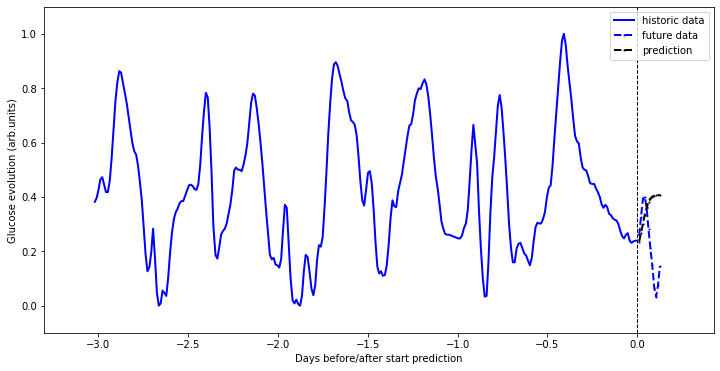

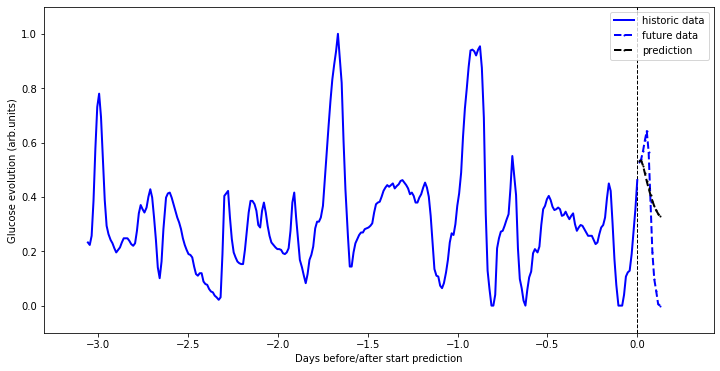

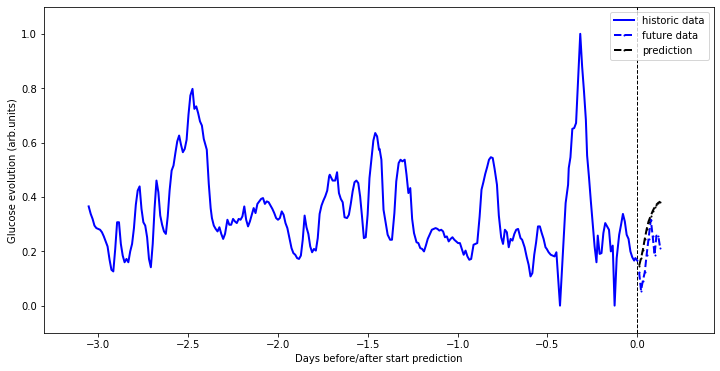

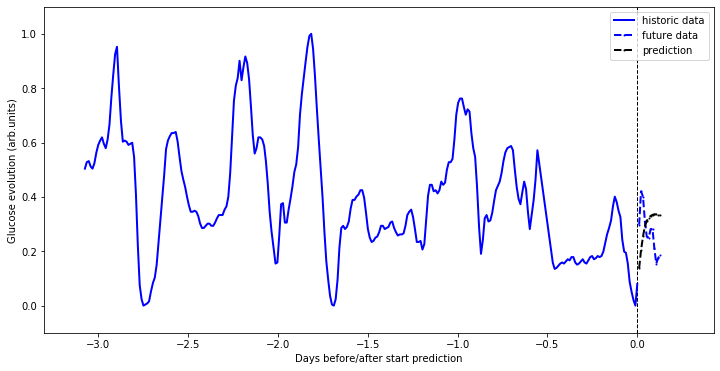

<Figure size 864x432 with 0 Axes>

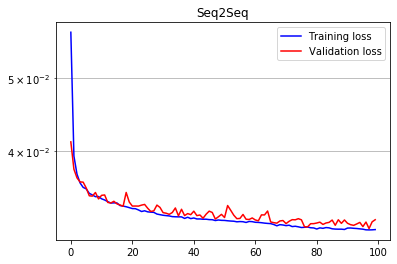

<Figure size 864x432 with 0 Axes>

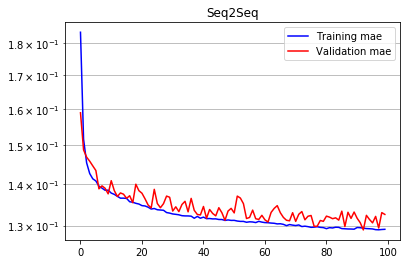

In [0]:
num_epochs = 100

num_layers_enc = 1
num_layers_dec = None
layers_dense = [64, 32, 8, 1]
neurons = 128

out_cat_dim = (6, 6) 
out_dim_input = 30 
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.1
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# droput in the input to the RNN does not work well. Better add Gaussian Noise
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, out_cat_dim, out_dim_input, 
    activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

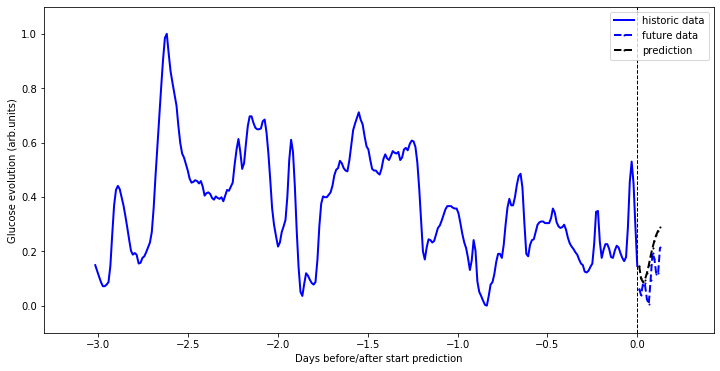

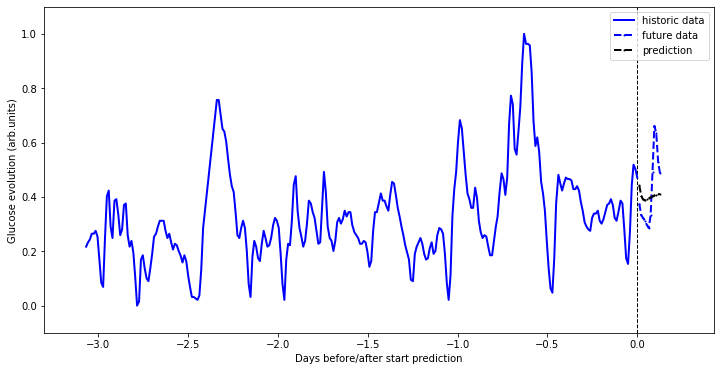

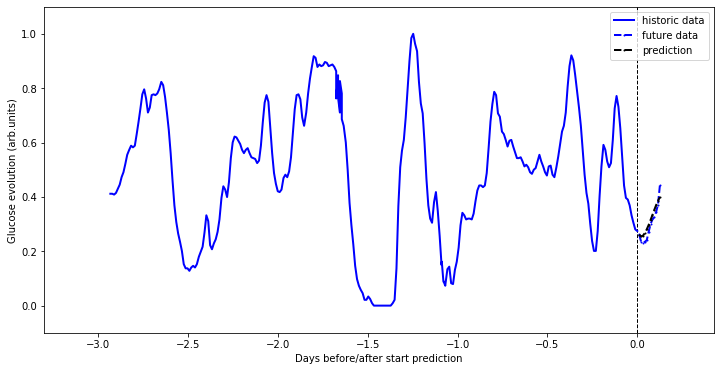

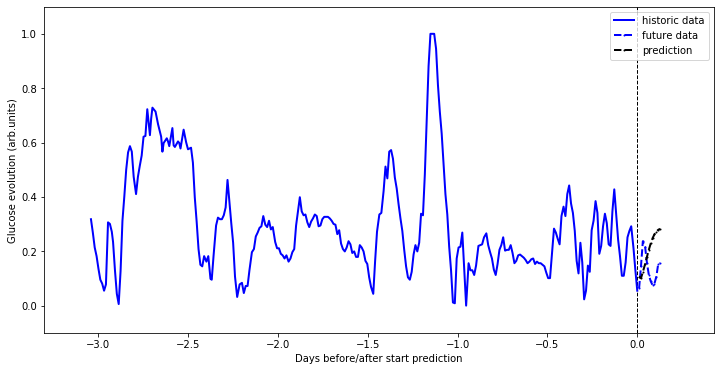

<Figure size 864x432 with 0 Axes>

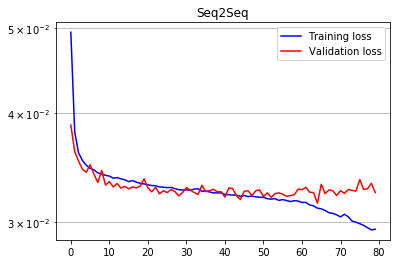

<Figure size 864x432 with 0 Axes>

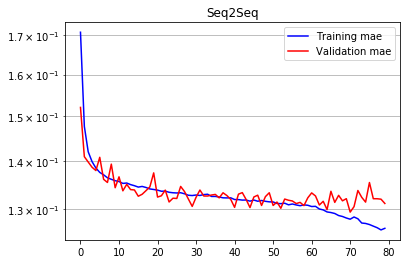

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

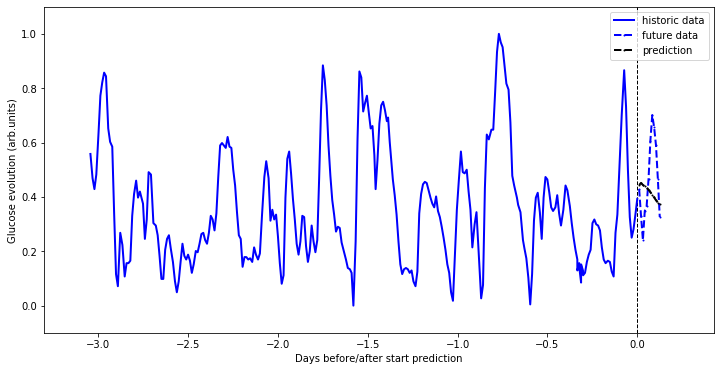

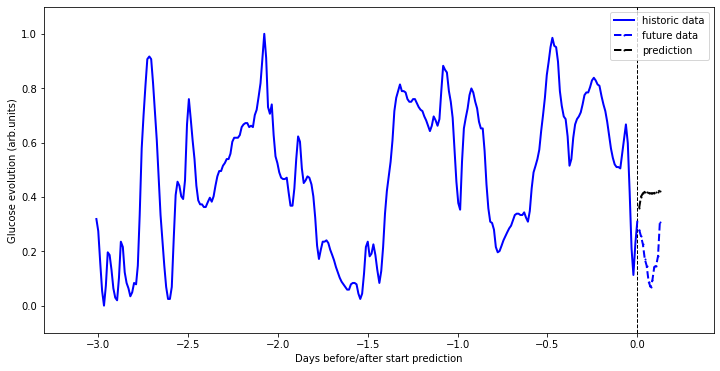

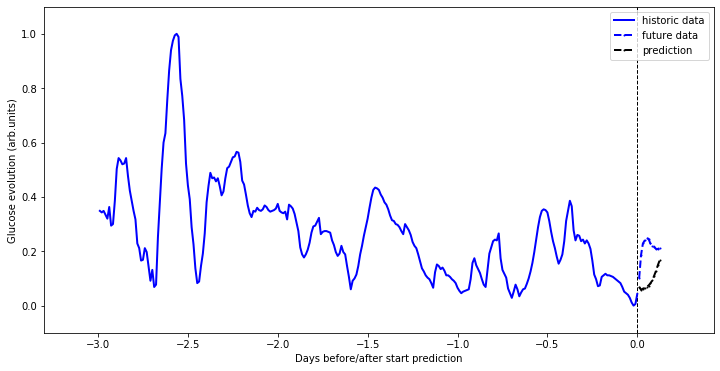

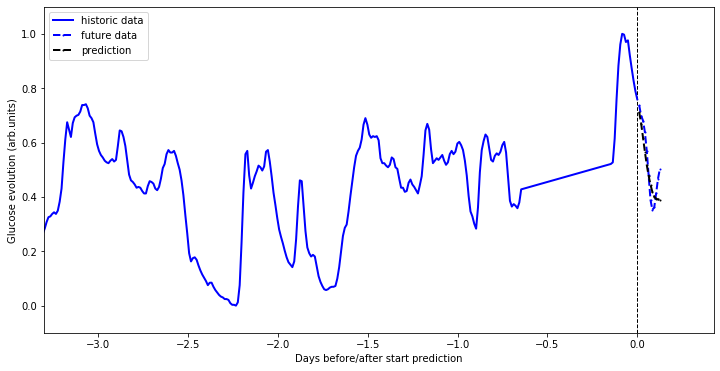

<Figure size 864x432 with 0 Axes>

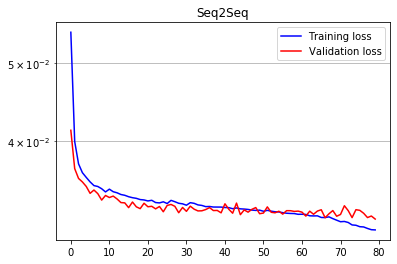

<Figure size 864x432 with 0 Axes>

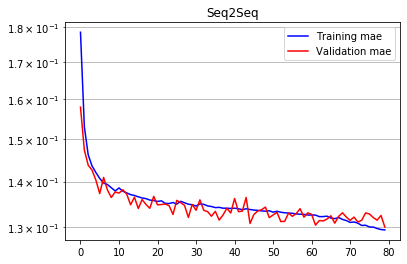

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

In [0]:
num_epochs = 80

num_layers_enc = 1
num_layers_dec = None
layers_dense = [64, 32, 8, 1]
neurons = 300

out_cat_dim = (6, 6) 
out_dim_input = 30
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.2
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

for dropout in [0.2, 0.3, 0.4]:
  m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
      history, future, start_char, neurons, out_cat_dim, out_dim_input, 
      activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
      activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
      lr, clip_value, num_epochs, train_batch, loss, metric, verbose)


Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

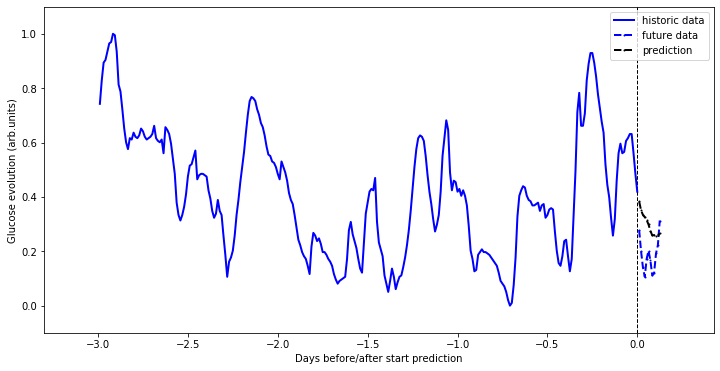

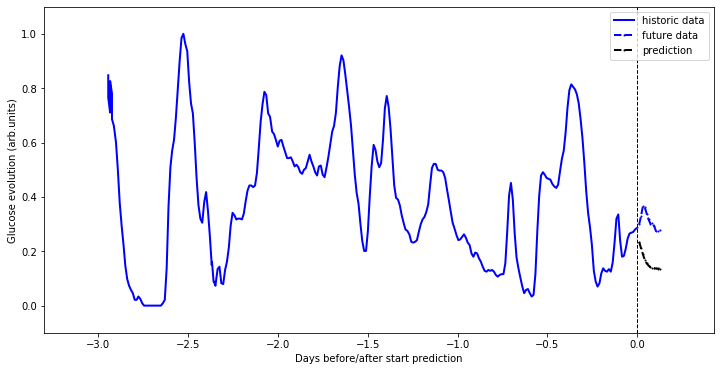

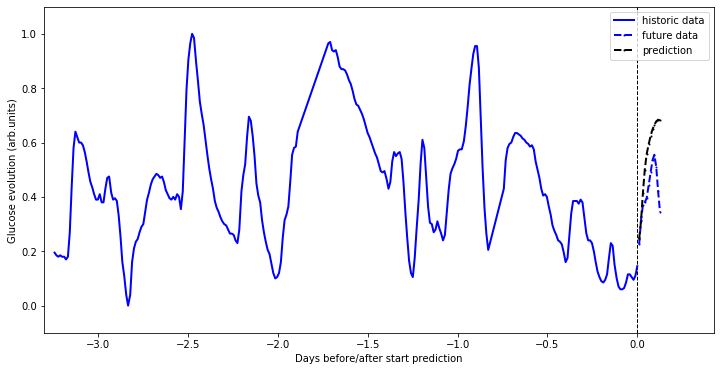

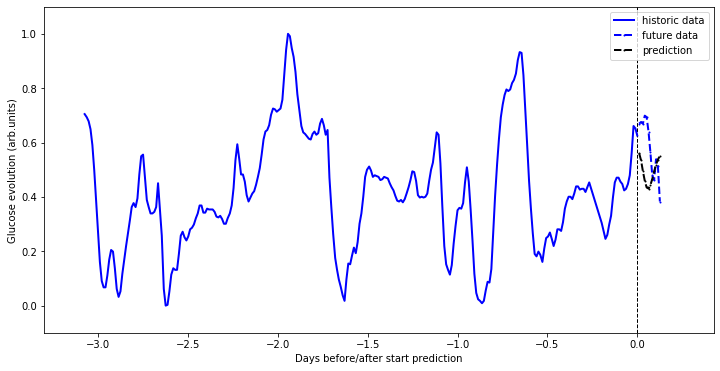

<Figure size 864x432 with 0 Axes>

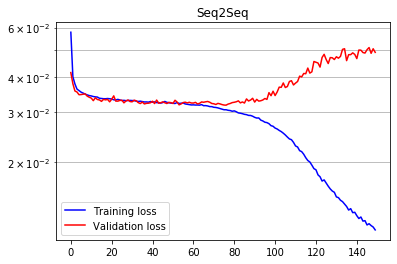

<Figure size 864x432 with 0 Axes>

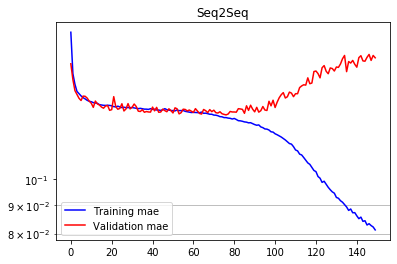

In [0]:
num_epochs = 150

num_layers_enc = 1
num_layers_dec = None
layers_dense = [64, 32, 8, 1]
neurons = 300

out_cat_dim = (6, 6) 
out_dim_input = 30
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.2
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

for dropout in [0.2]:
  m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
      history, future, start_char, neurons, out_cat_dim, out_dim_input, 
      activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
      activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
      lr, clip_value, num_epochs, train_batch, loss, metric, verbose)

In [0]:
num_epochs = 150

num_layers_enc = 1
num_layers_dec = None
layers_dense = [64, 32, 8, 1]
neurons = 300

out_cat_dim = (6, 6) 
out_dim_input = 30
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.5
mn_rec = 0.2
activation_dense = 'selu'

clip_value = 0.5
lr = 5e-4

# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

dropout = 0.5
m, training_logs = train_seq2seq(train_data, vad_data, train, vad, 
    history, future, start_char, neurons, out_cat_dim, out_dim_input, 
    activation_input, noise_input, num_layers_enc, num_layers_dec, layers_dense, 
    activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, loss, metric, verbose)

Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
_____________________________________________________________________________

KeyboardInterrupt: ignored

### Some results

* 1 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.1:

     loss: 0.0498 - mae: 0.1603 - val_loss: 0.0504 - val_mae: 0.1598

* 2 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.05:

    loss: 0.0376 - mae: 0.1425 - val_loss: 0.0374 - val_mae: 0.1410

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0359 - mae: 0.1375 - val_loss: 0.0353 - val_mae: 0.1358

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.3, mn_rec = 0.2:

    loss: 0.0317 - mae: 0.1288 - val_loss: 0.0371 - val_mae: 0.1388
    
  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.5, mn_rec = 0.1:

    loss: 0.0355 - mae: 0.1367 - val_loss: 0.0355 - val_mae: 0.1355**

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 1.0, mn_rec = 0.1:

    loss: 0.0350 - mae: 0.1354 - val_loss: 0.0364 - val_mae: 0.1386

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 10, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0362 - mae: 0.1381 - val_loss: 0.0360 - val_mae: 0.1394

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 50, mn_dense = 0.3, mn_rec = 0.1:

    loss: 0.0356 - mae: 0.1369 - val_loss: 0.0363 - val_mae: 0.1383

* 3 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (3, 3), out_dim_input = 20, mn_dense = 0.5, mn_rec = 0.1, epochs = 150:

    loss: 0.0309 - mae: 0.1279 - val_loss: 0.0312 - val_mae: 0.1294

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (6, 6), out_dim_input = 30, mn_dense = 0.5, mn_rec = 0.1, epochs = 150:

    loss: 0.0298 - mae: 0.1255 - val_loss: 0.0303 - val_mae: 0.1260

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (6, 6), out_dim_input = 30, mn_dense = 0.3, mn_rec = 0.1, epochs = 200:



* 4 day feature steps, 3 hours for label steps: 

  * layers_dense = [64, 32, 8, 1], neurons = 128, out_cat_dim = (6, 6), out_dim_input = 40, mn_dense = 0.5, mn_rec = 0.1, epochs = 150:

    loss: 0.0275 - mae: 0.1205 - val_loss: 0.0284 - val_mae: 0.1226

### Evaluation

In [0]:
input_test = get_columns(test_data[0][0])
target_test = test_data[1][:, :-1]
prediction_test = m.predict(input_test, batch_size=500, verbose=True)
loss, metric = m.evaluate(input_test, target_test)
print("Errors in test are mse={:.3f} and mae={:.3f}".format(loss, metric))


13137/13137 [==============================] - 4s 272us/sample - loss: 0.0336 - mae: 0.1316
Errors in test are mse=0.034 and mae=0.132


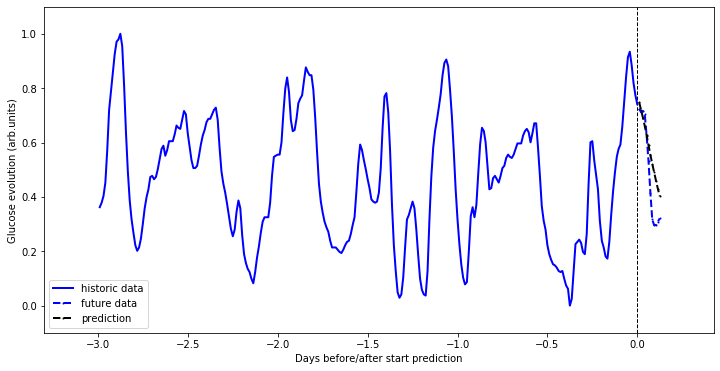

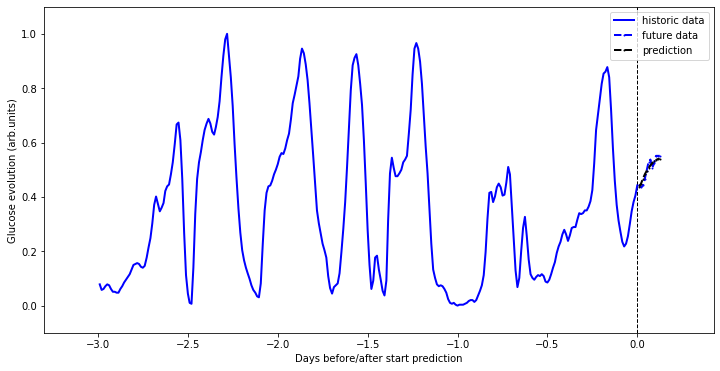

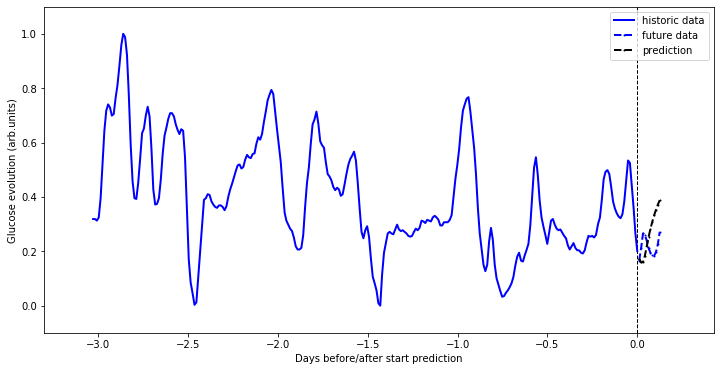

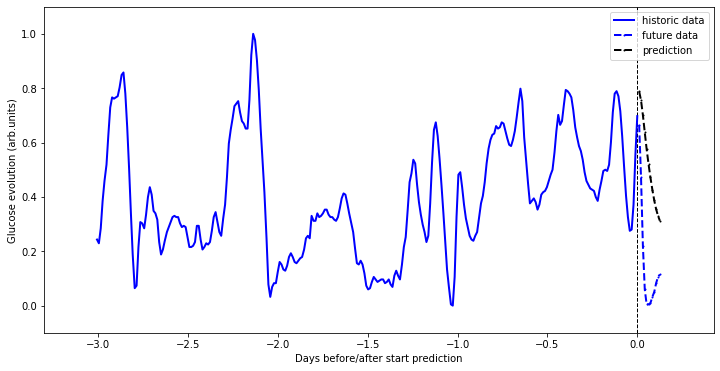

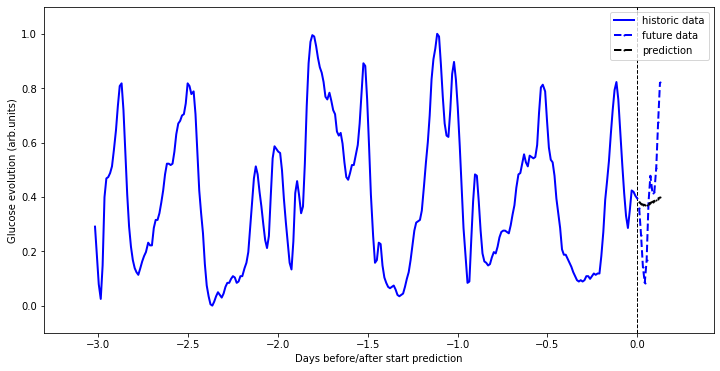

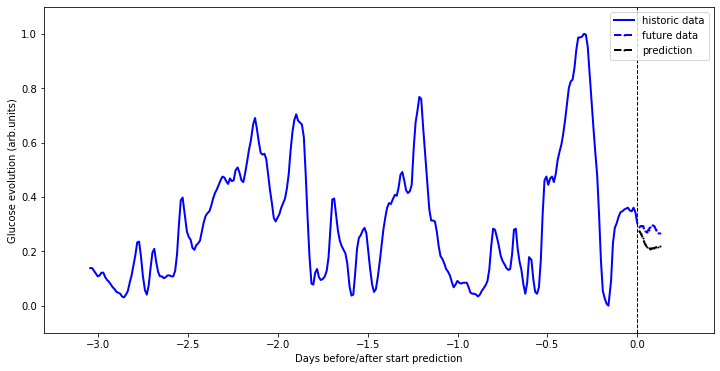

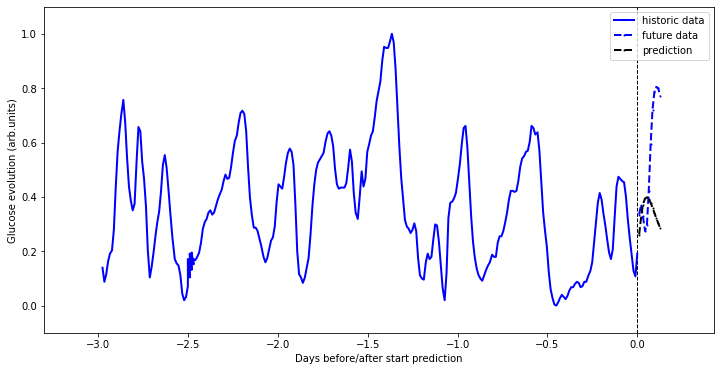

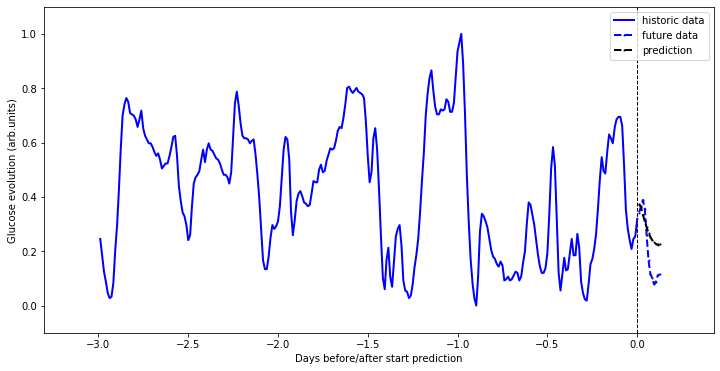

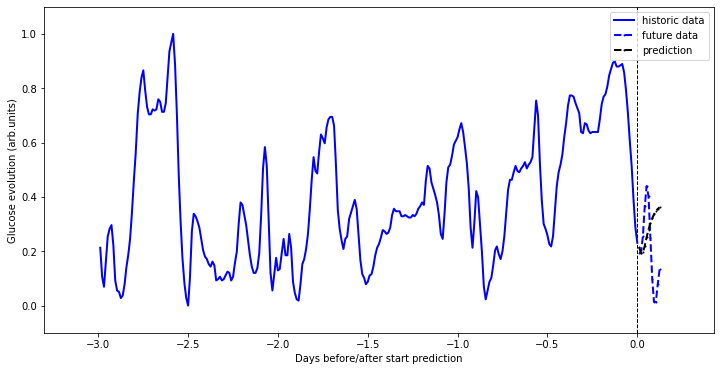

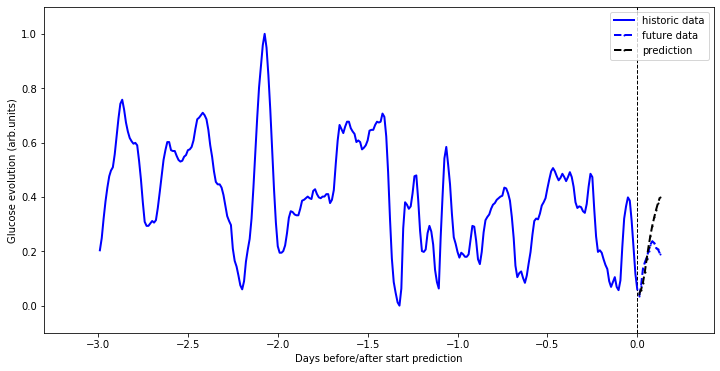

In [0]:
for _ in np.arange(10):
    plot_results(test, prediction_test, history, future)

## Seq2seq model with Teacher Forcing

### Models: encoder and decoder


In [0]:
def encoder_force(latent_dim, num_features, num_layers, mn_rec, dropout, recurrent_dropout):
    """
    Encode sequences with LSTMs 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return encoder input, output states and last output sequence; and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))

    # for loop to stack lstms, with returning sequences
    input_ = encoder_inputs
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
       input_ = lstm_(input_)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    encoder_output, state_h, state_c = encoder(input_)
    encoder_states = [state_h, state_c]
    print('Encoder output shape', encoder_output.shape)
    
    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=[encoder_output] + encoder_states, 
                          name='encoder_model_inference')
    
    print('Encoder done')

    return encoder_inputs, encoder_states, encoder_output, encoder_model

def decoder_force(encoder_states, encoder_output, latent_dim, future_steps, 
                  layers_dense, activation_dense, mn_dense, mn_rec, dropout, 
                  recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the encoder sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of prediction steps to be made. We add one more 
      step for the end of target sequence
    :param layers_dense: list with the number of neurons for each layer in the final mlp
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    decoder_inputs_seq = Input(shape=(None, 1))
    # Also use encoder ouptut as input 
    decoder_inputs_enc = RepeatVector(future_steps+1)(encoder_output)
    # feed as a list
    decoder_inputs = concatenate(inputs=[decoder_inputs_seq, decoder_inputs_enc], axis=-1)
    print('Decoder input done', decoder_inputs_seq.shape, decoder_inputs_enc.shape, decoder_inputs.shape)

    # Set up the decoder, using `encoder_states` as initial state.
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    print('Decoder lstm done', lstm_outputs.shape)
    # MLP for output sequences
    input_mlp = lstm_outputs
    mlp = []
    for neurons in layers_dense:
        decoder_dense = Dense(neurons, activation='selu', 
                              kernel_constraint=max_norm(mn_dense))
        mlp.append(decoder_dense)
        input_mlp = decoder_dense(input_mlp)
    decoder_outputs = input_mlp
    print('Decoder train done', input_mlp.shape)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    print('Decoder inference input states done')

    # Input sequences: here, we do not repeat the encoder_output vector, as we 
    # perform inference one step after another
    encoder_output_inf = Input(shape=(latent_dim))
    decoder_inputs_inf = RepeatVector(1)(encoder_output_inf)
    decoder_inputs_inf = concatenate(
        inputs=[decoder_inputs_seq, decoder_inputs_inf], axis=-1)
    print('Decoder inference inputs seq done', decoder_inputs_seq.shape, encoder_output_inf.shape, decoder_inputs_inf.shape)

    lstm_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs_inf, initial_state=decoder_states_inputs)
    print('Decoder inference lstm done')

    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = lstm_outputs_inference
    for layer in mlp:
        decoder_outputs_inference = layer(decoder_outputs_inference)
    print('Decoder inference mlp done')

    decoder_model = Model(
        inputs=[decoder_inputs_seq, encoder_output_inf] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    print('Decoder inference done')

    return decoder_inputs_seq, decoder_outputs, decoder_model

def seq2seq_force(history, future, latent_dim, num_features, num_layers_enc,
                  layers_dense, activation_dense, mn_dense, mn_rec, 
                  dropout, recurrent_dropout):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param num_layers_enc: number of stack layers in the encoder. 
        Last layer only returns states
    :param layers_dense: list with the number of neurons for each layer in the final mlp
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output, encoder_model = encoder_force(
        latent_dim, num_features, num_layers_enc, mn_rec, dropout, recurrent_dropout)
    print(encoder_model.summary())

    # decode
    print('Building the decoder')
    decoder_inputs, decoder_outputs, decoder_model = decoder_force(
        encoder_states, encoder_output, latent_dim, future, layers_dense,
        activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

### Inference


In [0]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_steps, start_char, batch_size):
    # Encode the input as state vectors.
    enc_output, enc_state_h, enc_state_c = encoder_model.predict(input_seq)
    states_value = [enc_state_h, enc_state_c]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((batch_size, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0, 0] = start_char

    # Sampling loop for a batch of sequences
    decoded_seq = np.zeros(shape=(batch_size, num_steps, 1), dtype=np.float)
    for i in np.arange(num_steps):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, enc_output] + states_value)
        
        out = output_tokens[:, 0, 0]
        decoded_seq[:, i, 0] = out

        # Update the target sequence (of length 1).
        target_seq[:, 0, 0] = out

        # Update states
        states_value = [h, c]

    return decoded_seq

def inner_loop(decoded_seq, dataset, encoder_model, decoder_model, history, future, start_char, 
               start, end, num_seq, batch_size, verbose):
    for idx in np.arange(start, end, step=batch_size):
        if idx >0 and verbose and idx % 500 == 0:
            print("Predicted %s sequences" % idx)
        indices = np.arange(idx, idx+batch_size)
        input_seq = dataset[indices, :history, :]
        if batch_size == 1:
            input_seq = input_seq[np.newaxis, :, :]
        decoded_seq_ = decode_sequence(input_seq, encoder_model, decoder_model, 
                                       future, start_char, batch_size)
        decoded_seq[indices, :] = np.squeeze(decoded_seq_)
    return decoded_seq, indices[-1]
    
def decode_sequences(dataset, encoder_model, decoder_model, history, future, start_char, batch_size, verbose=False):
    num_seq = dataset.shape[0]
    num_steps = num_seq // batch_size
    decoded_seq = np.zeros(shape=(num_seq, future))
    
    start = 0
    decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq-batch_size,
                                        num_seq, batch_size, verbose)
    batch_size = num_seq - last_idx -1 
    if batch_size > 0:
        start = last_idx+1
        decoded_seq, last_idx = inner_loop(decoded_seq, dataset, encoder_model, decoder_model, 
                                        history, future, start_char, start, num_seq,
                                        num_seq, batch_size, verbose)            
    return decoded_seq

### Training

In [0]:
def train_seq2seq_force(train_data, vad_data, train, vad, history, future, start_char, 
                        latent_dim, num_features, num_layers_enc, layers_dense,
                        activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
                        lr, clip_value, num_epochs, train_batch, prediction_batch, 
                        epochs_to_validation, loss, metric, verbose):

    m, enc, dec = seq2seq_force(history, future, 
                                latent_dim=neurons, 
                                num_features=num_features, 
                                num_layers_enc=num_layers_enc, 
                                layers_dense=layers_dense,
                                activation_dense=activation_dense, 
                                mn_dense=mn_dense, 
                                mn_rec=mn_rec, 
                                dropout=dropout, 
                                recurrent_dropout=recurrent_dropout)

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    training_logs = {'loss': [], 'val_loss': [], metric: [], 'val_{}'.format(metric): []}
    err_logs = np.zeros(shape=(num_epochs//epochs_to_validation, 3))
    k = 0
    for epoch in np.arange(num_epochs):
        print("Epoch number %s" %epoch)
        h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=1, 
                  validation_data=vad_data)
        training_logs = {k: v + h.history[k] for k, v in training_logs.items()}

        if (epoch +1) % epochs_to_validation == 0:
            prediction_train = decode_sequences(train, enc, dec, history, future, start_char, 
                                                batch_size=prediction_batch, verbose=verbose)
            err_train = mae(train, prediction_train, history, future)

            prediction_vad = decode_sequences(vad, enc, dec, history, future, start_char, 
                                              batch_size=prediction_batch, verbose=verbose)
            err_vad = mae(vad, prediction_vad, history, future)
            print('For epoch %s, the error in train and validation is MAE=(%.3f, %.3f)' % (epoch+1, err_train, err_vad))
            err_logs[k, :] = np.array([epoch, err_train, err_vad])
            k += 1

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)
    plot_metric(err_logs)
    return m, enc, dec, prediction_vad, err_logs, training_logs

Encoder output shape (None, 50)
Encoder done
Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  11000     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
None
Building the decoder
Decoder input done (None, None, 1) (None, 13, 50) (None, 13, 51)
Decoder lstm done (None, 13, 50)
Decoder train done (None, 13, 1)
Decoder inference input states done
Decoder inference inputs seq done (None, None, 1) (None, 50) (None, 1, 51)
Decoder inference lstm done
Decoder inference mlp done
Decoder inference done
Model: "decoder_model_inference"
_____________________________________________________________________________

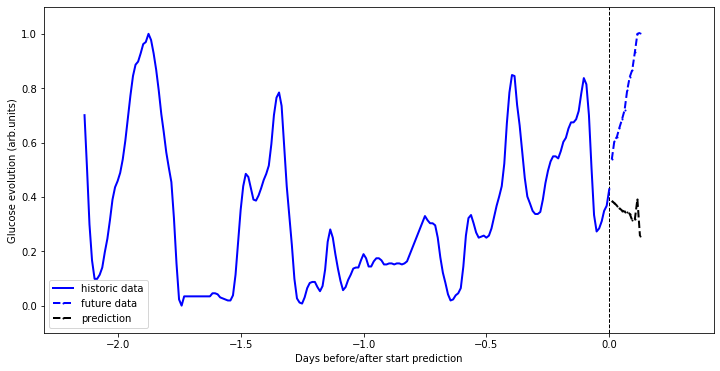

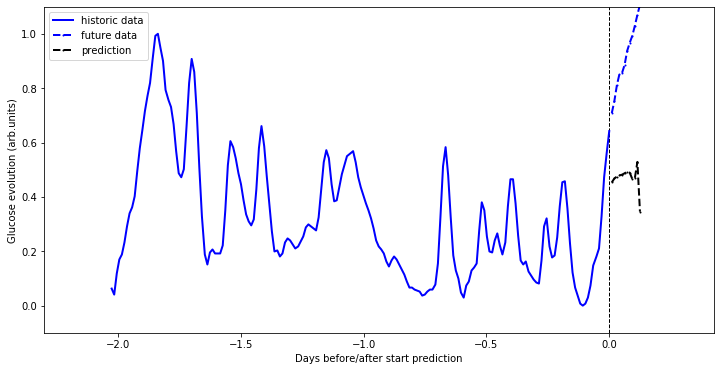

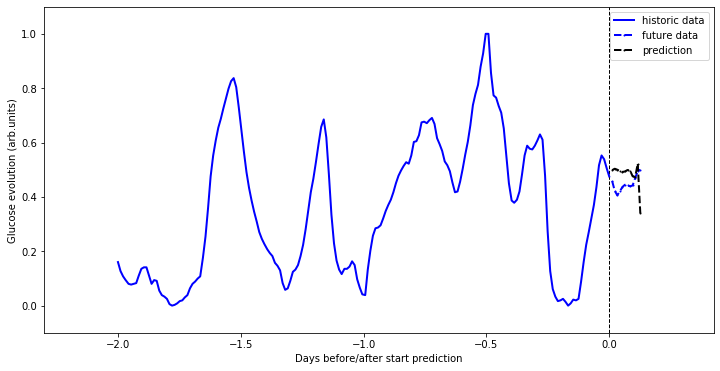

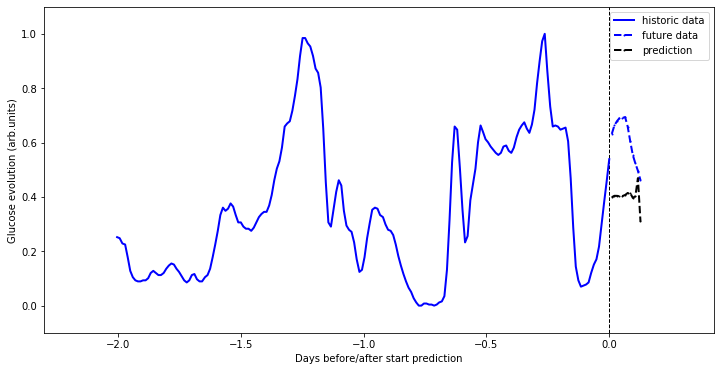

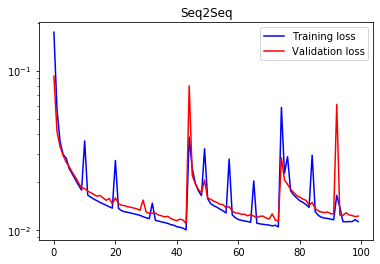

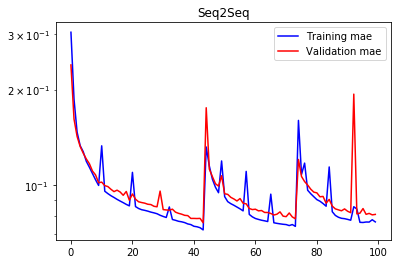

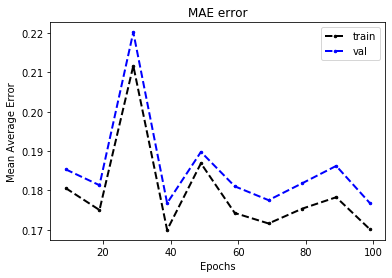

In [0]:
num_epochs = 100

num_layers_enc = 1
neurons = 50
num_features = 4
mn_dense = 0.5
mn_rec = 0.1
layers_dense = [20, 8, 1]
activation_dense = 'selu'
clip_value = 0.3
lr = 5e-4
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  
verbose = False

prediction_batch = 500
epochs_to_validation = 10
metric = 'mae'
loss = MSE

m, enc, dec, prediction_vad, err_logs, training_logs = train_seq2seq_force(
    train_data, vad_data, train, vad, 
    history, future, start_char, neurons, num_features, num_layers_enc, 
    layers_dense, activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
    lr, clip_value, num_epochs, train_batch, prediction_batch, 
    epochs_to_validation, loss, metric, verbose)


### Retrain best model with train and vad data

In [0]:
a1 = np.concatenate([train_data[0][0], vad_data[0][0]], axis=0)
a2 = np.concatenate([train_data[0][1], vad_data[0][1]], axis=0)
b = np.concatenate([train_data[1], vad_data[1]], axis=0)
train_vad_data = ((a1, a2), b)

msg = "Shapes of train+vad data are: input_enc: {}, input_dec: {} and output_dec: {}"
msg = msg.format(train_vad_data[0][0].shape, train_vad_data[0][1].shape, train_vad_data[1].shape)
print(msg)

Shapes of train+vad data are: input_enc: (93903, 144, 4), input_dec: (93903, 17, 1) and output_dec: (93903, 17, 1)


In [0]:
num_epochs = 150

num_layers = 1
neurons = 200
mn_dense = 0.5
mn_rec = 0.2

full_model, full_enc, full_dec = seq2seq(history, future, latent_dim=neurons, num_features=4, 
                      num_layers_enc=num_layers, activation_dense='elu', 
                      mn_dense=mn_dense, mn_rec=mn_rec)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=0.3), 
          loss=MSE, metrics=['mean_absolute_error'])
h = full_model.fit(x=train_vad_data[0], y=train_vad_data[1], batch_size=train_batch, epochs=num_epochs)

### Save best model

In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/models/"
outfolder = os.path.join(root, "noise_%s_train_replace_%s" %(noise, replace))
modelname = "layers_%s_neurons_%s_mn-dense_%.1f_mn-rec_%.1f" %(num_layers, neurons, mn_dense, mn_rec)
outpath = os.path.join(outfolder, modelname)

import re
outpath_bash = re.sub(" ", "\ ", outpath)

!mkdir -p $outpath_bash

full_model.save(os.path.join(outpath, 'seq2seq_model.h5'))
full_enc.save(os.path.join(outpath, 'encoder_model.h5'))
full_dec.save(os.path.join(outpath, 'decoder_model.h5'))

### Evaluate on the test set


In [0]:
prediction_test = decode_sequences(test, enc, dec, history, future, start_char, 
                                   batch_size=500, verbose=True)
err_test = mae(test, prediction_test, history, future)

print("MAE in test set is %.3f" %err_test)

Predicted 500 sequences
Predicted 1000 sequences
Predicted 1500 sequences
Predicted 2000 sequences
Predicted 2500 sequences
Predicted 3000 sequences
Predicted 3500 sequences
Predicted 4000 sequences
Predicted 4500 sequences
Predicted 5000 sequences
Predicted 5500 sequences
Predicted 6000 sequences
Predicted 6500 sequences
Predicted 7000 sequences
Predicted 7500 sequences
Predicted 8000 sequences
Predicted 8500 sequences
Predicted 9000 sequences
Predicted 9500 sequences
Predicted 10000 sequences
MAE in test set is 0.240


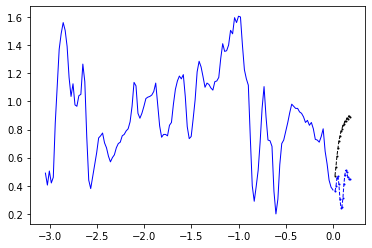

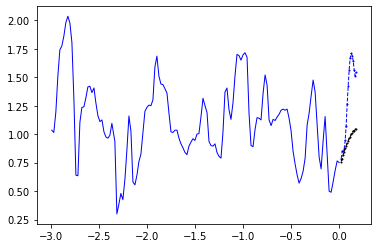

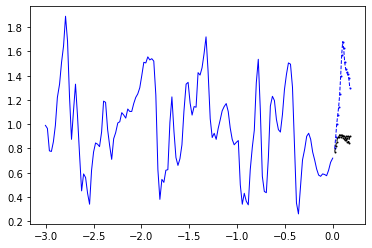

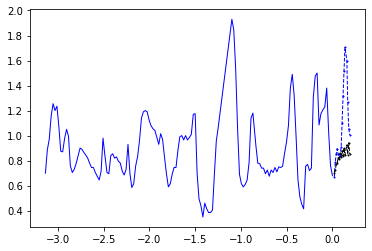

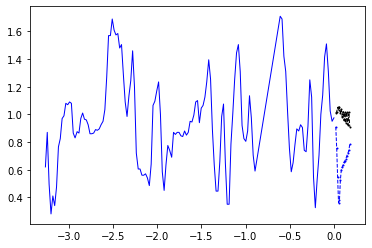

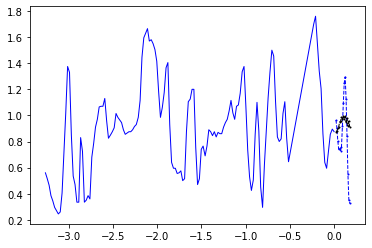

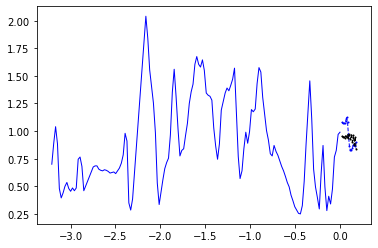

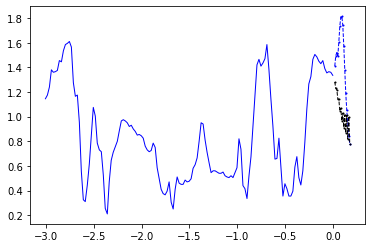

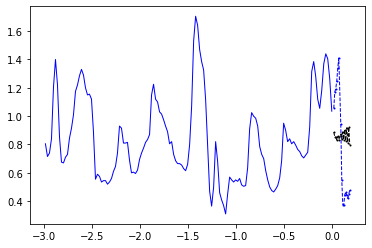

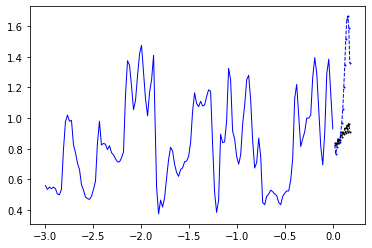

In [0]:
for _ in np.arange(10):
  plot_results(test, prediction_test, history, future)

## Seq2seq with Curriculum Learning

https://www.tensorflow.org/tutorials/text/text_generation

https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/



## Seq2seq with input CNN features

### Model

In [0]:
def cnn_features(time_series, filters, list_kernel_size, activation, mn_conv):
    """

    Method to extract features form a time series using Convolutional Neural Networks

    Note that we must preserve the length of the input sequence, so that we can 
    concatenate with other features with same temporal steps latter on. 

    :param time_series: layer of shape=(batch_size, input_length, 1). 
        batch_size, and input_legth are not specified (set to None)
    :param filters: Integer, the dimensionality of the output space 
        (i.e. the number of output filters in the convolution).
    :param list_kernel_size: a list of integers specifying the length of the 1D convolution window.
    :param activation: Activation function to use. If you don't specify anything, 
        no activation is applied (ie. "linear" activation: a(x) = x).
    :param mn_conv: max norm constraint function applied to the kernel matrix.
    :return a layer of convolved features, of shape 
        (batch_size, input_length, filters * len(list_kernel_size))
    """
    cnn_list = []
    for kernel_size in list_kernel_size:
        # outputs of shape (None, input_length, filters)
        cnn = Convolution1D(filters=filters, kernel_size=kernel_size, strides=1, 
                            padding='same', kernel_constraint=max_norm(mn_conv))
        cnn = cnn(time_series)
        cnn_list.append(cnn)
    out = concatenate(cnn_list, axis=-1)
    
    return out

def process_input(out_cat_dim, out_dim, activation, noise, num_conv_layers, filters, 
                  list_kernel_size, activation_cnn, mn_conv, dropout_conv):
    """
    Method to process categorical/numerical features and add noise.
    Features are next concatenate and passed through a Dense layer.

    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :param filters: Integer, the dimensionality of the output space 
        (i.e. the number of output filters in the convolution).
    :param list_kernel_size: a list of integers specifying the length of the 1D convolution window.
    :param activation_cnn: Activation function to use. If you don't specify anything, 
        no activation is applied (ie. "linear" activation: a(x) = x).
    :param mn_conv: max norm constraint function applied to the kernel matrix.
    :return a list of Input layers (time_interval, day_of_week, hour_of_day, sugar_level),
        as well as the processed inputs (a layer of shape=(batch_size, None, out_dim))
    """
    # Define Input layers for numerical and categorical variables
    day_of_week = Input(shape=(None, ))
    hour_of_day = Input(shape=(None, ))
    time_interval = Input(shape=(None, 1))
    sugar_level = Input(shape=(None, 1))
    tensor_inputs = [time_interval, hour_of_day, day_of_week, sugar_level]

    # create embeddings for categorical variables
    day_of_week = Embedding(input_dim=7, output_dim=out_cat_dim[0])(day_of_week)
    hour_of_day = Embedding(input_dim=24, output_dim=out_cat_dim[1])(hour_of_day)
    
    # Add noise to sugar level feature
    if noise > 0.0:
        sugar_level = GaussianNoise(stddev=noise)(sugar_level)

    # Concatenate all inputs toghether
    inputs = [time_interval, hour_of_day, day_of_week, sugar_level]
    inputs = concatenate(inputs, axis=-1)

    # generate features from CNNs. Note that num_conv_layers cannot be larger than 5
    # since we downsample by 2 in each iteration (and 24*4 is divisible by 32, but not by 64)
    print(filters)
    for i in np.arange(num_conv_layers):
        inputs = cnn_features(inputs, filters[i], list_kernel_size, activation, mn_conv)
        inputs = AveragePooling1D(pool_size=2, strides=2, padding='valid')(inputs)
        inputs = Dropout(rate=dropout_conv)(inputs)

    if out_dim is not None:
        inputs = Dense(out_dim, activation=activation)(inputs)
    
    return tensor_inputs, inputs

def encoder(out_cat_dim, out_dim, activation, noise, latent_dim, 
            num_layers, mn_rec, dropout, recurrent_dropout, num_conv_layers, filters, 
            list_kernel_size, activation_cnn, mn_conv, dropout_conv):
    """
    Encode sequences with LSTMs 

    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim: final output dimension after the Dense layer. 
    :param activation: activation of the final Dense layer
    :param noise: noise level used in the GaussianNoise layer (aka, stddev)
    :param latent_dim: dimension of the encoding vectors
    :param num_features_cat: number of input categorical features
    :param num_features_num: number of input numerical features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :param filters: Integer, the dimensionality of the output space 
        (i.e. the number of output filters in the convolution).
    :param list_kernel_size: a list of integers specifying the length of the 1D convolution window.
    :param activation_cnn: Activation function to use. If you don't specify anything, 
        no activation is applied (ie. "linear" activation: a(x) = x).
    :param mn_conv: max norm constraint function applied to the kernel matrix.
    :return encoder input and output states, and last output of the sequence
    """
    # process input data: categorical variables, noise, cnn_features, etc.
    tensor_inputs, inputs = process_input(out_cat_dim, out_dim, activation, noise, 
                                          num_conv_layers, filters, list_kernel_size, activation_cnn, 
                                          mn_conv, dropout_conv)
    
    # for loop to stack lstms, with returning sequences
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec),
                    recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                    recurrent_dropout=recurrent_dropout)
       inputs = lstm_(inputs)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec), 
                   recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                   recurrent_dropout=recurrent_dropout)
    encoder_output, state_h, state_c = encoder(inputs)
    encoder_states = [state_h, state_c]

    return tensor_inputs, encoder_states, encoder_output

def decoder(encoder_states, encoder_output, latent_dim, 
            num_layers, layers_dense,
            future_steps, activation_dense, mn_dense, mn_rec, 
            dropout, recurrent_dropout):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param encoder_output: last output of the sequence
    :param latent_dim: dimension of the decoding vectors
    :param future_steps: number of predictions. 
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :return decoder input and output sequences
    """
    # use encoder_output as input to the decoder
    decoder_inputs = RepeatVector(future_steps)(encoder_output)

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec), 
                        recurrent_constraint=max_norm(mn_rec), dropout=dropout, 
                        recurrent_dropout=recurrent_dropout)
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    # MLP for output sequences
    input_mlp = lstm_outputs
    for neurons in layers_dense:
        decoder_dense = Dense(neurons, activation='selu', 
                              kernel_constraint=max_norm(mn_dense))
        input_mlp = decoder_dense(input_mlp)
    decoder_outputs = input_mlp
 
    return decoder_inputs, decoder_outputs

def seq2seq(history, future, latent_dim, out_cat_dim, out_dim_input, activation_input, 
            noise_input, num_layers_enc, num_layers_dec, layers_dense,
            activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout, 
            num_conv_layers, filters, list_kernel_size, activation_cnn, 
            mn_conv, dropout_conv):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param out_cat_dim: tuple with output dimensions of categorcial embeddings
        (For day_of_week and hour_of_day variables)
    :param out_dim_input: final output dimension after the Dense layer in the
        initial preprocessing
    :param activation_input: activation of the final Dense layer in the 
        initial preprocessing
    :param noise_input: noise level used in the GaussianNoise layer (aka, stddev)
        in the initial preprocessing
    :param num_layers_enc: number of stack layers in the encoder. 
        Last layer only returns states
    :param num_layers_dec: number of stack layers in the decoder. Not used yet.
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :param dropout: Float between 0 and 1. Fraction of the units to drop for the 
        linear transformation of the inputs.
    :param recurrent_dropout: Float between 0 and 1. Fraction of the units to 
        drop for the linear transformation of the recurrent state.
    :param filters: Integer, the dimensionality of the output space 
        (i.e. the number of output filters in the convolution).
    :param list_kernel_size: a list of integers specifying the length of the 1D convolution window.
    :param activation_cnn: Activation function to use. If you don't specify anything, 
        no activation is applied (ie. "linear" activation: a(x) = x).
    :param mn_conv: max norm constraint function applied to the kernel matrix.
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_output = encoder(
        out_cat_dim, out_dim_input, activation_input, noise_input, latent_dim, 
        num_layers_enc, mn_rec, dropout, recurrent_dropout, num_conv_layers, 
        filters, list_kernel_size, activation_cnn, mn_conv, dropout_conv)

    # decode
    decoder_inputs, decoder_outputs = decoder(
        encoder_states, encoder_output, latent_dim, num_layers_dec,
        layers_dense, future, activation_dense, mn_dense, 
        mn_rec, dropout, recurrent_dropout)

    # Training model
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs, 
                  name='seq2seq_training_model')
    print(model.summary())

    return model

### Training

In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, sugar_level = np.split(data, 
        indices_or_sections=4, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    return [time_interval, hour_of_day, day_of_week, sugar_level]

def train_seq2seq(train_data, vad_data, train, vad, history, future, start_char, 
                  latent_dim, out_cat_dim, out_dim_input, activation_input, 
                  noise_input, num_layers_enc, num_layers_dec, layers_dense, 
                  activation_dense, mn_dense, mn_rec, dropout, recurrent_dropout,
                  num_conv_layers, filters, list_kernel_size, activation_cnn, 
                  mn_conv, dropout_conv,
                  lr, clip_value, num_epochs, train_batch, loss, metric, verbose):
    m = seq2seq(history, future,
                latent_dim=neurons,
                out_cat_dim=out_cat_dim,
                out_dim_input=out_dim_input,
                activation_input=activation_input,
                noise_input=noise_input,
                num_layers_enc=num_layers_enc,
                num_layers_dec=num_layers_dec,
                layers_dense=layers_dense,
                activation_dense=activation_dense,
                mn_dense=mn_dense,
                mn_rec=mn_rec,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                num_conv_layers=num_conv_layers,
                filters=filters, 
                list_kernel_size=list_kernel_size, 
                activation_cnn=activation_cnn, 
                mn_conv=mn_conv, 
                dropout_conv=dropout_conv
                )

    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=clip_value), 
              loss=loss, metrics=[metric])

    # we remove the end of sentence from target data (used in more complicated models)
    input_train = get_columns(train_data[0][0])
    target_train = train_data[1][:, :-1]

    input_vad = get_columns(vad_data[0][0])
    target_vad = vad_data[1][:, :-1]

    h = m.fit(x=input_train, y=target_train, batch_size=train_batch, epochs=num_epochs, 
              validation_data=(input_vad, target_vad))
    
    training_logs = h.history

    # get predictions for the validation set
    prediction_vad = m.predict(input_vad, batch_size=500, verbose=True)

    for _ in np.arange(4):
        plot_results(vad, prediction_vad, history, future)

    plot_train_history(training_logs, 'Seq2Seq', metric='loss')
    plot_train_history(training_logs, 'Seq2Seq', metric=metric)

    return m, training_logs

[16, 32, 64, 128, 128]
Model: "seq2seq_training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 6)      144         input_2[0][0]                    
______________________________________________________

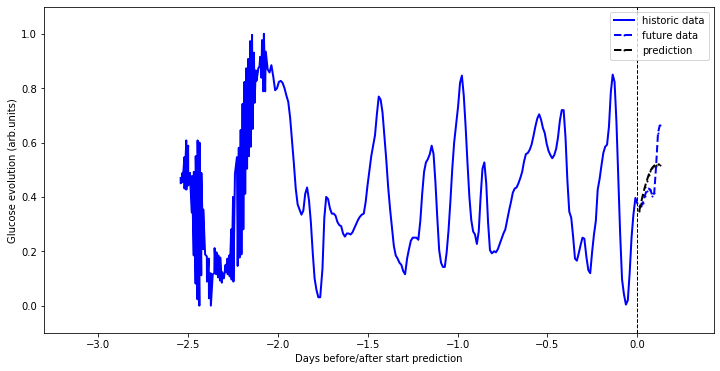

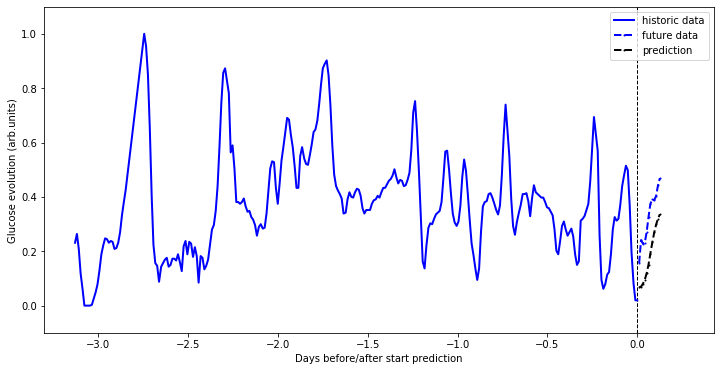

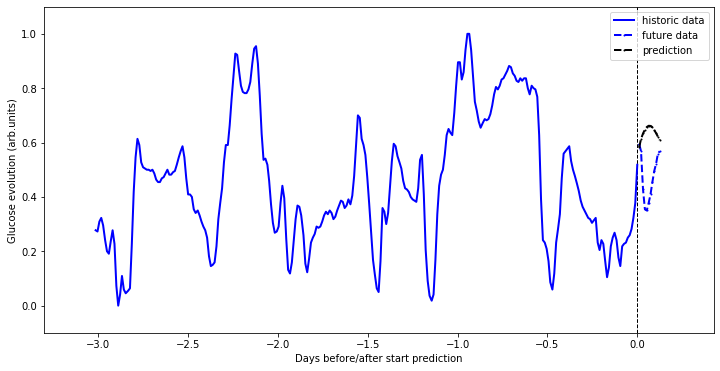

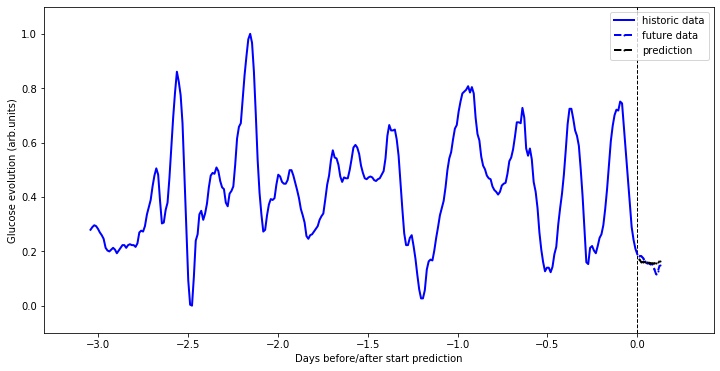

<Figure size 864x432 with 0 Axes>

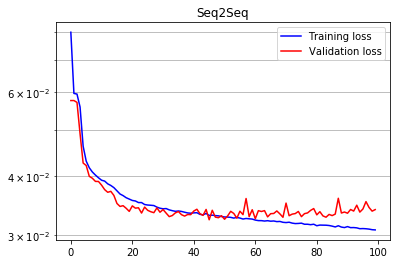

<Figure size 864x432 with 0 Axes>

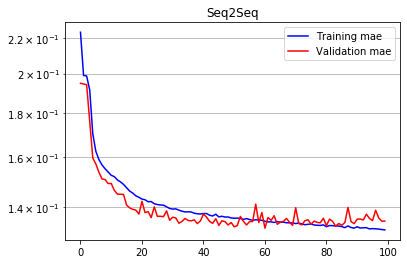

In [0]:
num_epochs = 100

num_layers_enc = 1
num_layers_dec = 100
layers_dense = [64, 32, 8, 1]
neurons = 128

out_cat_dim = (6, 6) 
out_dim_input = 100
activation_input = 'selu'
noise_input = 0.0

mn_dense = 0.3
mn_rec = 0.1
activation_dense = 'selu'

num_conv_layers = 5
filters = [16, 32, 64, 128, 128]
list_kernel_size = [1, 3, 5]
activation_cnn = 'selu' 
mn_conv = 0.2
dropout_conv = 0.6

clip_value = 0.5
lr = 5e-4

# droput in the input to the RNN does not work well. Better add Gaussian Noise
dropout = 0.0
# better avoid using the recurrent_dropout, so as to take advantage of cuDNN implementation
recurrent_dropout = 0.0  

verbose = False

metric = 'mae'
loss = MSE

m_cnn, training_logs_cnn = train_seq2seq(
    train_data=train_data, 
    vad_data=vad_data, 
    train=train, 
    vad=vad, 
    history=history, 
    future=future, 
    start_char=start_char, 
    latent_dim=neurons, 
    out_cat_dim=out_cat_dim, 
    out_dim_input=out_dim_input, 
    activation_input=activation_input, 
    noise_input=noise_input, 
    num_layers_enc=num_layers_enc, 
    num_layers_dec=num_layers_dec, 
    layers_dense=layers_dense, 
    activation_dense=activation_dense, 
    mn_dense=mn_dense, 
    mn_rec=mn_rec, 
    dropout=dropout, 
    recurrent_dropout=recurrent_dropout,
    num_conv_layers=num_conv_layers, 
    filters=filters, 
    list_kernel_size=list_kernel_size, 
    activation_cnn=activation_cnn, 
    mn_conv=mn_conv, 
    dropout_conv=dropout_conv,
    lr=lr, 
    clip_value=clip_value, 
    num_epochs=num_epochs, 
    train_batch=train_batch, 
    loss=loss, 
    metric=metric, 
    verbose=verbose)